# Project: Herseninfarct
### Team: Undefined
### Teamleden:
- **Sebastiaan Westerlaken**
- **Michal Kakol**

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime

# Import src
from src.preprocessing import clean_data, normalize_data
from src.eda import eda_sum, impossible_values
from src.model import train_knn, train_lr, train_svm, train_decision_tree, train_random_forest, train_gradient_boosting, train_xgboost, train_custom_ensemble
from src.other_functions import evaluate_knn, export_submission

# Data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_example = pd.read_csv("data/sample_submission.csv")
df_submission = pd.DataFrame(columns=["id", "stroke"])

## Makkelijk overzicht data

| **Kolomnaam**                    | **Beschrijving**                                                                                |
| -------------------------------- | ----------------------------------------------------------------------------------------------- |
| `id`                             | Unieke identificatiecode voor elke persoon in de dataset.                                       |
| `age`                            | Leeftijd van de persoon (in jaren).                                                             |
| `hypertension`                   | Of de persoon een hoge bloeddruk (hypertensie) heeft (1 = Ja, 0 = Nee).                         |
| `heart_disease`                  | Of de persoon een hartaandoening heeft (1 = Ja, 0 = Nee).                                       |
| `avg_glucose_level`              | Gemiddeld glucosegehalte in het bloed (in mg/dL).                                               |
| `bmi`                            | Body Mass Index (BMI) — maat voor vetpercentage op basis van lengte en gewicht.                 |
| `gender_Female`                  | True als de persoon **vrouw** is; anders False.                                                 |
| `gender_Male`                    | True als de persoon **man** is; anders False.                                                   |
| `gender_Other`                   | True als de persoon een **ander gender** heeft; anders False.                                   |
| `ever_married_No`                | True als de persoon **nog nooit getrouwd** is; anders False.                                    |
| `ever_married_Yes`               | True als de persoon **ooit getrouwd** is; anders False.                                         |
| `work_type_Govt_job`             | True als de persoon een **overheidsbaan** heeft; anders False.                                  |
| `work_type_Never_worked`         | True als de persoon **nog nooit gewerkt** heeft; anders False.                                  |
| `work_type_Private`              | True als de persoon in de **private sector** werkt; anders False.                               |
| `work_type_Self-employed`        | True als de persoon **zelfstandig ondernemer** is; anders False.                                |
| `work_type_children`             | True als de persoon een **kind** is (nog geen onderdeel van de beroepsbevolking); anders False. |
| `Residence_type_Rural`           | True als de persoon in een **landelijk** gebied woont; anders False.                            |
| `Residence_type_Urban`           | True als de persoon in een **stedelijk** gebied woont; anders False.                            |
| `smoking_status_formerly smoked` | True als de persoon **vroeger rookte**; anders False.                                           |
| `smoking_status_never smoked`    | True als de persoon **nooit gerookt** heeft; anders False.                                      |
| `smoking_status_smokes`          | True als de persoon **momenteel rookt**; anders False.                                          |
| `stroke`                         | Doelvariabele — of de persoon ooit een **beroerte (stroke)** heeft gehad (1 = Ja, 0 = Nee).     |

*(ChatGPT, 2025, prompt 1: Markdown Table Help)*

# 1. Exploratieve Data Analyse<br>

Hieronder voeren wij eerst de exploratieve data analyse uit die wordt aangeroepen vanuit het src.eda bestand.

---------------------------------------------------------------------------------------------------
Dataset Info
---------------------------------------------------------------------------------------------------
Rijen: 33550, Kolommen: 22
Datatypen:
id                                  int64
age                               float64
hypertension                        int64
heart_disease                       int64
avg_glucose_level                 float64
bmi                               float64
gender_Female                        bool
gender_Male                          bool
gender_Other                         bool
ever_married_No                      bool
ever_married_Yes                     bool
work_type_Govt_job                   bool
work_type_Never_worked               bool
work_type_Private                    bool
work_type_Self-employed              bool
work_type_children                   bool
Residence_type_Rural                 bool
Residence_type_Urban               

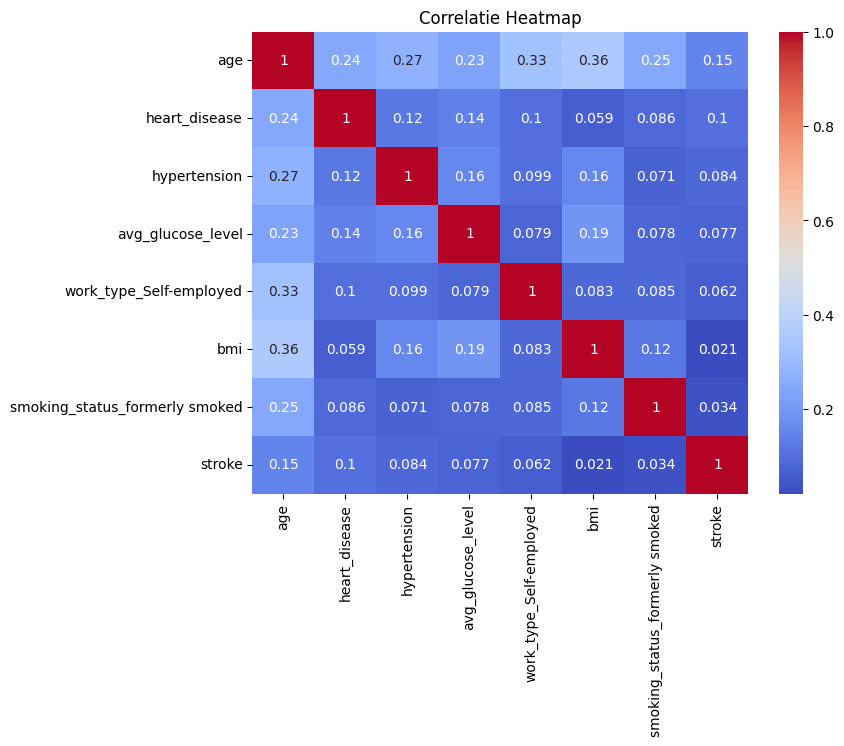

---------------------------------------------------------------------------------------------------
Correlaties met 'stroke':
---------------------------------------------------------------------------------------------------
age: 0.149
heart_disease: 0.105
hypertension: 0.084
avg_glucose_level: 0.077
work_type_Self-employed: 0.062
smoking_status_formerly smoked: 0.034
bmi: 0.021
---------------------------------------------------------------------------------------------------
Verdeling Non-Boolean Features
---------------------------------------------------------------------------------------------------
Statistieken voor age:
count    33550.000000
mean        41.815312
std         22.477423
min          0.080000
25%         24.000000
50%         43.000000
75%         59.000000
max         82.000000
Name: age, dtype: float64
IQR: 35.00
Skewness: -0.08
Kurtosis: -1.00


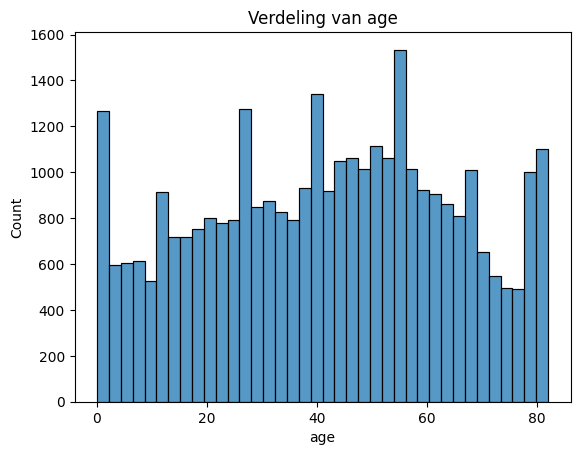

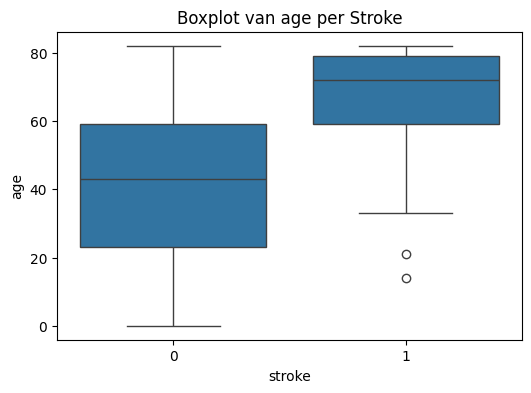

Statistieken voor avg_glucose_level:
count    33550.000000
mean       103.587081
std         42.127396
min         55.010000
25%         77.460000
50%         91.320000
75%        111.437500
max        281.590000
Name: avg_glucose_level, dtype: float64
IQR: 33.98
Skewness: 1.72
Kurtosis: 2.43


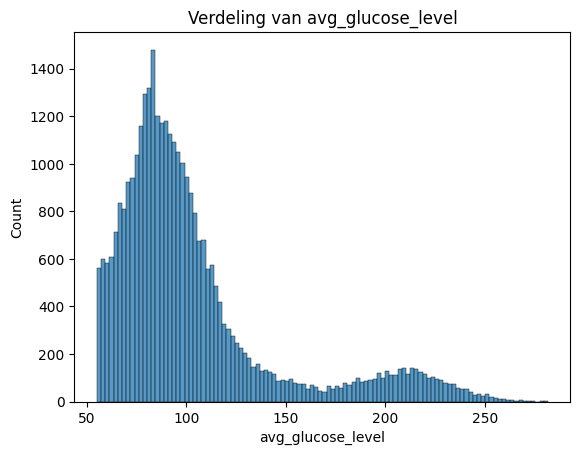

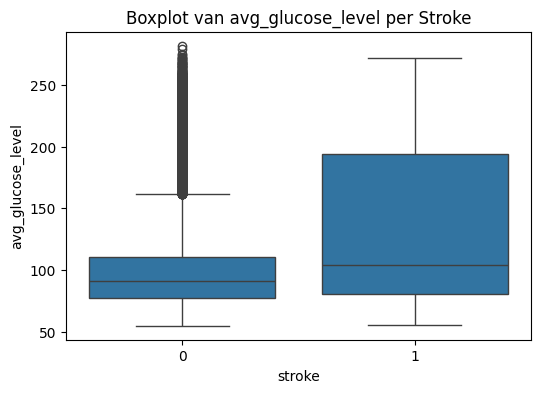

Statistieken voor bmi:
count    33550.000000
mean        28.601216
std          7.782248
min         10.100000
25%         23.300000
50%         27.700000
75%         32.800000
max         97.600000
Name: bmi, dtype: float64
IQR: 9.50
Skewness: 0.92
Kurtosis: 2.13


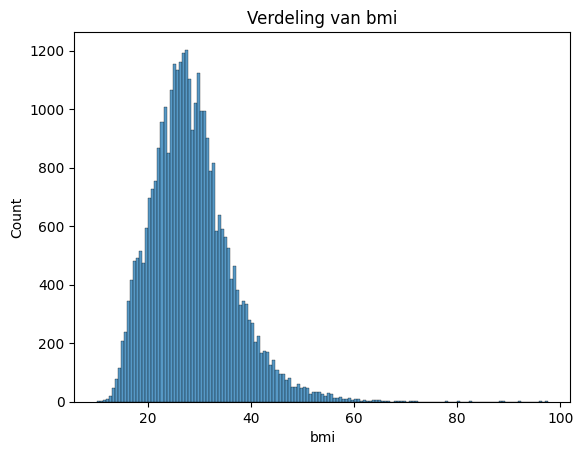

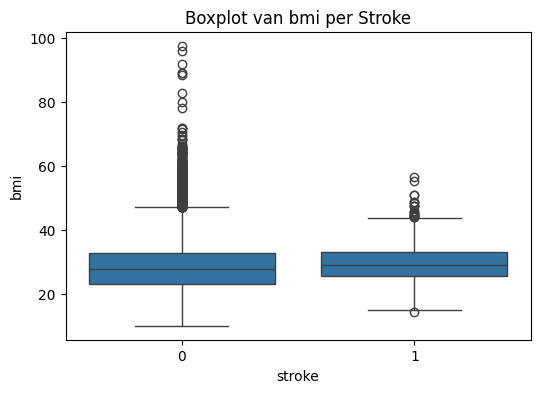

---------------------------------------------------------------------------------------------------
Verdeling Boolean Features
---------------------------------------------------------------------------------------------------
heart_disease
0    32106
1     1444
Name: count, dtype: int64

hypertension
0    30593
1     2957
Name: count, dtype: int64

work_type_Self-employed
False    28424
True      5126
Name: count, dtype: int64

smoking_status_formerly smoked
False    27889
True      5661
Name: count, dtype: int64

stroke
0    33033
1      517
Name: count, dtype: int64

---------------------------------------------------------------------------------------------------
Controle op onmogelijke waarden
---------------------------------------------------------------------------------------------------

 Onmogelijke waarden in bmi:
175      64.1
407      65.8
689      62.0
1130     63.0
1153     60.5
         ... 
31813    71.7
32108    64.7
32572    65.5
33022    61.3
33277    60.1
Name: b

In [2]:
eda_sum(df_train)

---

## Exploratieve Data Analyse

### Beoordeling van de dataset

De dataset kan direct gebruikt worden met Scikit-Learn. Hij is ingeladen als een DataFrame, er zijn geen ontbrekende waarden en alle kolommen zijn numeriek. Het gaat om een combinatie van booleans, integers en floats.

Wat betreft de meetniveaus:
- Nominaal: heart_disease, hypertension, work_type_Self-employed, stroke
- Ordinaal: geen
- Interval: geen
- Ratio: age, avg_glucose_level, bmi

Hoewel sommige nominale variabelen als integers zijn opgeslagen, zijn ze binair van aard. Voor machine learning hoeft hier niets aan veranderd te worden.

---

### Correlaties en belangrijkste variabelen

Om te kijken naar mogelijke multicollineariteit en te zien welke features het meest relevant zijn voor de target (stroke), is een correlatie-analyse gedaan.

Sterkst gecorreleerde variabelen met stroke zijn:
- age 0.149
- heart_disease 0.105
- hypertension 0.084
- avg_glucose_level 0.077
- work_type_Self-employed 0.062
- smoking_status_formerly smoked 0.034
- bmi 0.021

Geen enkele correlatie is hoger dan 0.2, dus alle features kunnen worden behouden voor modelbouw.

---

### Belangrijkste observaties

Leeftijd blijkt duidelijk een belangrijke factor: jongere mensen hebben bijna geen kans op een beroerte, het risico neemt vooral toe na 35 jaar. BMI lijkt minder invloed te hebben dan verwacht. Voor roken valt op dat voormalige rokers iets meer risico lijken te hebben dan huidige rokers. Het gemiddeld glucosegehalte ligt hoger bij mensen met een beroerte, maar strokes komen voor bij een breed bereik aan waarden.

---

### Statistische kenmerken

Voor de niet-boolean variabelen zijn enkele kernstatistieken berekend. Age heeft een standaarddeviatie van 22.48 en is bijna symmetrisch verdeeld, met een licht afgeplatte verdeling. Avg_glucose_level ligt gemiddeld rond 104 met een standaarddeviatie van 42, de verdeling is rechts-scheef door enkele uitschieters. Deze uitschieters kunnen relevant zijn voor het model.

---

### Klasse-ongelijkheid

De dataset is sterk uit balans, met slechts 517 positieve stroke-gevallen. Daarom worden bij het evalueren van modellen vooral de F1-score en de confusion matrix gebruikt, omdat alleen accuracy niet genoeg zegt over de prestaties op de minderheidsklasse.

---

### Samenvatting

De dataset is geschikt voor machine learning. Er zijn geen missende waarden, geen sterke correlaties en de belangrijkste voorspellende variabelen lijken age, heart_disease, hypertension en avg_glucose_level. Vanwege de sterke class imbalance moet bij modeltraining extra aandacht worden besteed aan geschikte evaluatiemetrics.


---
## 1.1 Data opschonen en standaardiseren

In [ ]:
# Opschonen
df_train_clean = clean_data(df_train)
df_test_clean = clean_data(df_test)

# Features + target
X = df_train_clean.drop(columns=['stroke'])
y = df_train_clean['stroke']

# Splitsen in train / validatie
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Standaardiseren en align train & test automatisch
X_scaled_train, X_scaled_val, scaler = normalize_data(X_train, X_val)
X_scaled_test, _, _ = normalize_data(X_train, df_test_clean)
X_scaled_train.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
21761,999,-0.924639,-0.311805,-0.212204,-0.633968,1.460447,False,True,False,True,...,True,False,False,False,False,False,True,False,False,False
22172,38471,0.277480,-0.311805,-0.212204,0.626586,0.365047,False,True,False,False,...,False,False,False,True,False,False,True,False,False,False
31165,8123,-0.746547,-0.311805,-0.212204,-0.653917,-0.954713,True,False,False,True,...,True,False,False,False,False,False,True,False,True,False
22405,51151,-0.256795,-0.311805,-0.212204,-0.684552,0.048304,False,True,False,False,...,False,False,False,True,False,True,False,False,True,False
7613,15974,1.212462,-0.311805,-0.212204,2.293235,1.447250,True,False,False,False,...,False,False,False,True,False,False,True,False,True,False


---
# 2. Evaluatie

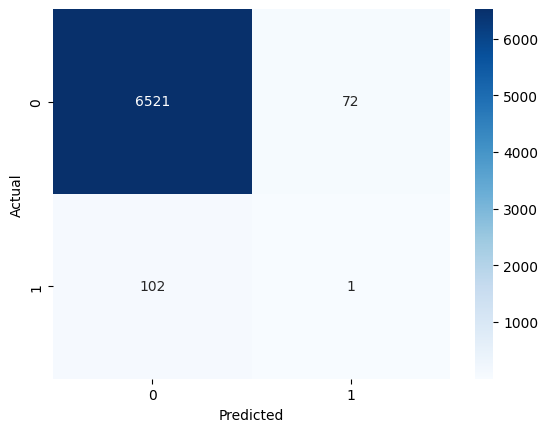

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6593
           1       0.01      0.01      0.01       103

    accuracy                           0.97      6696
   macro avg       0.50      0.50      0.50      6696
weighted avg       0.97      0.97      0.97      6696



In [4]:
evaluate_knn(X_scaled_train, X_scaled_val, y_train, y_val, n_neighbors=1)

---

## Evaluatie van het model

Om het KNN-model te beoordelen gebruiken we enkele standaard metrics: accuracy, precision, recall en F1-score. Al deze waarden zijn af te leiden uit de confusion matrix, die laat zien hoe goed het model voorspellingen maakt.

---

### Confusion matrix

Voor het model met n_neighbors gelijk aan 1 ziet de confusion matrix er als volgt uit:

- Actual zonder stroke voorspeld als geen stroke: 6521
- Actual zonder stroke voorspeld als stroke: 72
- Actual met stroke voorspeld als geen stroke: 102
- Actual met stroke voorspeld als stroke: 1

In termen van de standaard terminologie betekent dit:
- True Negatives: 6521
- False Positives: 72
- False Negatives: 102
- True Positives: 1

---

### Uitleg van de metrics

Accuracy meet het aantal correcte voorspellingen, in dit geval ongeveer 97 procent. Dit lijkt hoog, maar is misleidend door de scheve verdeling van de klassen.

Precision laat zien hoe vaak de voorspelde positieve gevallen echt positief zijn. Voor dit model is dat maar 0.01, dus het model voorspelt veel te vaak een stroke terwijl dat niet klopt.

Recall geeft aan hoeveel van de echte strokes het model herkent. Ook dit is 0.01, wat betekent dat bijna alle strokes gemist worden.

De F1-score combineert precision en recall tot één waarde die beide aspecten meeweegt. Bij scheve datasets geeft dit een realistischer beeld van het model.

---

### Waarom F1-score belangrijk is

De dataset bevat veel meer mensen zonder stroke dan met stroke. Bij zulke datasets kan een model dat altijd “geen stroke” voorspelt toch een hoge accuracy halen. Daarom is de F1-score hier een betere maatstaf. Het laat zien hoe goed het model de kleine positieve klasse oppikt en geeft een eerlijker beeld van de prestaties bij het detecteren van strokes.

---

# 3. Modelleren en uitleg modellen

---

## Model 1: K-Nearest Neighbors (KNN)

Hoe het model werkt:
KNN is een niet-parametrisch classificatiemodel dat een nieuwe observatie indeelt op basis van de afstand tot de dichtstbijzijnde trainingspunten. Meestal wordt de Euclidische afstand gebruikt, wat de rechte lijn tussen twee punten meet:

$$
d(p, q) = \sqrt{\sum_i (p_i - q_i)^2}
$$

Een alternatief is de Manhattan afstand, die de afstand langs de assen berekent:

$$
d(p, q) = \sum_i |p_i - q_i|
$$

Het model kiest de klasse van het nieuwe punt op basis van de meerderheid van de $k$ dichtstbijzijnde buren.

---

Waarom standaardisatie belangrijk is:
Omdat KNN afstanden vergelijkt tussen features, moeten alle features op dezelfde schaal staan. Zonder standaardisatie kunnen features met grotere waarden, zoals inkomen, de afstand te veel domineren vergeleken met kleinere waarden zoals leeftijd. Dit kan de voorspellingen van het model vervormen.

---

Beste hyperparameters:
- metric = euclidean
- k = 7
- weights = distance

Met deze instellingen behaalt het model een F1-score van 0.034.

Op een oude KNN met soortgelijke hyperparameters maar alleen K = 11 hadden we een betere F1: 0.076. Hellaas is het ons niet meer gelukt om dit te kunnen reprocuderen, verder is het ook onduidelijk waarom het opeens slechter is geworden.

---

Regularisatie bij KNN:<br>
De parameter $k$ werkt bij dit model als een soort regularisatie:
- Een kleine $k$ betekent dat het model sterk reageert op individuele datapunten en kan overfitten.
- Een grotere $k$ maakt het model gladder en helpt bij generalisatie.

Daarnaast zorgt weights = distance ervoor dat buren die dichterbij liggen meer invloed hebben op de voorspelling, wat zorgt voor een stabieler resultaat.<br>
*(1.6. Nearest Neighbors, n.d.)*

In [5]:
# Train KNN
knn_model, knn_params, knn_f1 = train_knn(X_scaled_train, y_train)

# Evaluatie
y_val_pred = knn_model.predict(X_scaled_val)
val_f1_knn = f1_score(y_val, y_val_pred)

print("Validation F1 score:", val_f1_knn)
print(classification_report(y_val, y_val_pred))

Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}
Best F1 score: 0.03680350911446193
Validation F1 score: 0.034381551362683435
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      6593
           1       0.02      0.40      0.03       103

    accuracy                           0.66      6696
   macro avg       0.50      0.53      0.41      6696
weighted avg       0.97      0.66      0.78      6696



---

## Model 2: Logistic Regression

Hoe het model werkt:
Logistische regressie voorspelt de kans dat een observatie tot klasse 1 behoort met behulp van de sigmoidfunctie:

$$
P(y=1 | x) = \frac{1}{1 + e^{-(w^T x + b)}}
$$

Als deze kans groter is dan 0.5 voorspelt het model klasse 1, anders klasse 0.

---

Loss-functie:
Om te meten hoe goed de voorspellingen zijn wordt de log-loss gebruikt, ook bekend als binaire cross-entropy:

$$
L(y, \hat{y}) = - [y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})]
$$

---

Gradient Descent:
Het model past de gewichten aan door de loss te minimaliseren met gradient descent:

$$
w_{\text{new}} = w_{\text{old}} - \alpha \frac{\partial L}{\partial w}
$$

Hierbij is α de learning rate. Bijvoorbeeld, als de gradient 4 is en α 0.1, wordt w aangepast met 0.4 richting het minimum van de loss.

---

Regularisatie en overfitting:
Regularisatie helpt overfitting te voorkomen door grote coëfficiënten te straffen.

- L1 (Lasso) kan sommige gewichten nul maken en werkt zo ook als feature selectie.
- L2 (Ridge) maakt gewichten kleiner zonder ze nul te maken, waardoor het model beter generaliseert.

---

Beste hyperparameters:
- C = 0.005
- penalty = l1
- solver = liblinear

Met deze instellingen behaalt het model een F1-score van 0.148.<br>
*(1.1. Linear Models, n.d.)*

In [6]:
# Train Logistic Regression
lr_model, lr_params, lr_f1 = train_lr(X_scaled_train, y_train)

# Evaluatie
y_val_pred = lr_model.predict(X_scaled_val)
val_f1_lr = f1_score(y_val, y_val_pred)

print("Validation F1 score:", val_f1_lr)
print(classification_report(y_val, y_val_pred))

Best Params: {'lr__C': 0.005, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Best F1 score: 0.14224062581912295
Validation F1 score: 0.14794520547945206
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      6593
           1       0.10      0.26      0.15       103

    accuracy                           0.95      6696
   macro avg       0.55      0.61      0.56      6696
weighted avg       0.97      0.95      0.96      6696



---

## Model 3: Support Vector Machine (SVM)

Hoe het model werkt:<br>
SVM is een classificatiemodel dat een optimale scheidingslijn, of hypervlak, zoekt om de twee klassen van elkaar te scheiden met de grootst mogelijke marge:

$$
\text{maximize } \frac{2}{||w||} \text{ onder de constraint } y_i (w^T x_i + b) \ge 1
$$

Hierbij zijn:
- ($w$) de gewichten, ($b$) de bias
- ($x_i$) de featurevector van observatie ($i$)
- ($y_i$ in ${-1, 1}$) de klasse van observatie ($i$)

---

Kernel en Kernel Trick:<br>
Wanneer data niet lineair scheidbaar zijn, kan een kernel $K(x_i, x_j)$ de data transformeren naar een hogere dimensie:

$$
K(x_i, x_j) = \phi(x_i)^T \phi(x_j)
$$

De kernel trick maakt het mogelijk $\phi(x)$ niet expliciet te berekenen, waardoor het model efficiënter blijft. Bijvoorbeeld, met twee features $(x_1, x_2)$ en een linear kernel:

$$
K(x_i, x_j) = x_i^T x_j = x_{i1} x_{j1} + x_{i2} x_{j2}
$$

---

Loss-functie:<br>
SVM gebruikt hinge loss:

$$
L(y, \hat{y}) = \max(0, 1 - y \hat{y})
$$

Met $\hat{y} = w^T x + b$ . Het verlies is nul als een voorbeeld correct is geclassificeerd met marge groter dan of gelijk aan 1, anders neemt het lineair toe.

---

Regularisatie:<br>
De C-parameter reguleert de balans tussen correcte classificatie en maximale marge.
- Hoger C betekent minder foutacceptatie
- Lager C laat een grotere marge toe

De totale loss met regularisatie kan worden weergegeven als:

$$
\min_w \frac{1}{2} ||w||^2 + C \sum_i \max(0, 1 - y_i (w^T x_i + b))
$$

---

Gradient / Optimalisatie:<br>
Het model past de gewichten aan op een manier dat de som van de margin-fouten en de regularisatie zo klein mogelijk wordt.

---

Beste hyperparameters:
- C = 0.01
- kernel = linear

Met deze instellingen behaalt het model een F1-score van 0.148.

Voordeel / Nadeel:<br>
SVM kan goed omgaan met hogere dimensionale data, maar RBF/poly kernels zijn traag bij grote datasets.<br>
*(1.4. Support Vector Machines, n.d.)*<br>
*(Wikipedia contributors, 2025)*

In [7]:
# Train SVM
svm_model, svm_params, svm_f1 = train_svm(X_scaled_train, y_train)

# Evaluatie
y_val_pred = svm_model.predict(X_scaled_val)
val_f1_svm = f1_score(y_val, y_val_pred)

print("Validation F1 score:", val_f1_svm)
print(classification_report(y_val, y_val_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Params: {'svm__estimator__C': 0.01}
Best F1 score: 0.13975355079124685
Validation F1 score: 0.14785992217898833
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6593
           1       0.12      0.18      0.15       103

    accuracy                           0.97      6696
   macro avg       0.56      0.58      0.57      6696
weighted avg       0.97      0.97      0.97      6696



---

## Model 4: Decision Tree

Hoe het model werkt:
Decision Tree splitst de data op basis van beslissingen over features. Elke splitsing verdeelt de data in twee takken totdat een stopcriterium is bereikt, zoals een maximale diepte of minimaal aantal voorbeelden in een blad.

---

Splitsingscriteria:
De splitsing wordt gekozen op basis van het criterium dat de impurity of onzekerheid het meest vermindert. Twee veelgebruikte criteria zijn:

- Gini impurity:

$$
Gini = 1 - \sum_{i=1}^{C} p_i^2
$$

- Entropy of Information Gain:

$$
Entropy = - \sum_{i=1}^{C} p_i \log_2(p_i)
$$

Hierbij is $(p_i)$ de kans dat een voorbeeld tot klasse $(i)$ behoort.

---

Regularisatie en Pruning:
Om overfitting te voorkomen kunnen verschillende parameters worden gebruikt:
- max_depth: maximale boomdiepte
- min_samples_split: minimaal aantal voorbeelden nodig om een knoop te splitsen
- min_samples_leaf: minimaal aantal voorbeelden per blad
- Pruning: takken die weinig bijdragen worden verwijderd

Pruning haalt takken weg die weinig bijdragen; dit helpt overfitting voorkomen, maar als je te veel weghaalt kan het model te simpel worden.

---

Beste hyperparameters:
- criterion: entropy
- max_depth: 5
- min_samples_split: 2
- min_samples_leaf: 1

Met deze instellingen behaalt het model een F1-score van 0.10.

Voordeel:<br>
Decision Trees zijn makkelijk te visualiseren en te begrijpen.<br>
*(1.10. Decision Trees, n.d.)*

In [8]:
# Train DT
dt_model, dt_params, dt_f1 = train_decision_tree(X_scaled_train, y_train)

# Evaluatie
y_val_pred = dt_model.predict(X_scaled_val)
val_f1_dt = f1_score(y_val, y_val_pred)

print("Validation F1 score:", val_f1_dt)
print(classification_report(y_val, y_val_pred))

Best Params: {'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Best F1 score: 0.09888025810005739
Validation F1 score: 0.09973753280839895
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      6593
           1       0.07      0.18      0.10       103

    accuracy                           0.95      6696
   macro avg       0.53      0.57      0.54      6696
weighted avg       0.97      0.95      0.96      6696



## Model 5: Ensembles: Random Forest, Gradient Boosted Trees en XGBoost

---

Bagging vs Boosting:
> Bagging (Bootstrap Aggregating) traint meerdere modellen onafhankelijk op verschillende subsets van de data. Dit vermindert de variance en voorkomt overfitting.<br>
> Boosting traint modellen achter elkaar, waarbij elke nieuwe boom focust op de fouten van erdere bomen. Dit kan een betere prestate opleveren, maar is sequential en vaak dus trager.

---

Random Forest (RF):<br>
Random Forest combineert meerdere beslisbomen via bagging, oftewel bootstrap aggregation. Elke boom wordt onafhankelijk getraind, waardoor training relatief snel kan verlopen en parallel uitgevoerd wordt.<br>
Belangrijke hyperparameters zijn n_estimators, max_depth, min_samples_split, min_samples_leaf en criterion. 
De beste instellingen voor dit model zijn:
- criterion = gini
- max_depth = 5
- min_samples_leaf = 2
- min_samples_split = 2
- n_estimators = 150

Met deze instellingen behaalt het model een F1-score van 0.10.

Voordeel / Nadeel:<br>
parallel trainbaar en robuust, maar minder goed bij scheve datasets of zeldzame klassen.

---

Gradient Boosted Trees (GBT):<br>
GBT traint meerdere bomen achter elkaar met boosting. Elke nieuwe boom corrigeert de fouten van de vorige bomen. Dit geeft vaak betere prestaties, maar de training duurt langer omdat het sequential is.<br>
Belangrijke hyperparameters zijn n_estimators, learning_rate, max_depth, min_samples_split en min_samples_leaf.<br>
De beste instellingen zijn:<br> 
- learning_rate = 0.05
- max_depth = 2
- min_samples_leaf = 1
- min_samples_split = 2
- n_estimators = 100

Dit levert een F1-score van 0.114.

Voordeel / Nadeel:<br>
Vaak hoge acuraccy, maar training is sequential en daardoor vrij langzaam; gevoelig voor overfitting bij te diepe bomen.

---

XGBoost:<br>
XGBoost is een geavanceerde vorm van boosting, die door optimalisaties zoals parallel split search sneller kan trainen. Extra hyperparameters zoals subsample en colsample_bytree helpen bij regularisatie en verminderen variance.<br> Belangrijke hyperparameters zijn n_estimators, learning_rate, max_depth, subsample en colsample_bytree.<br>
De beste instellingen zijn:
- colsample_bytree = 0.8
- learning_rate = 0.02
- max_depth = 2
- n_estimators = 200
- subsample = 0.8

Dit model behaalt een F1-score van 0.130.<br>
*(1.11. Ensembles: Gradient Boosting, Random Forests, Bagging, Voting, Stacking, n.d.)*<br>
*(XGBoost Documentation — Xgboost 3.0.5 Documentation, n.d.)*

In [9]:
# Train models
rf_model, rf_params, rf_f1 = train_random_forest(X_scaled_train, y_train)
gb_model, gb_params, gb_f1 = train_gradient_boosting(X_scaled_train, y_train)
xg_model, xg_params, xg_f1 = train_xgboost(X_scaled_train, y_train)

# Evaluatie
y_val_pred_rf = rf_model.predict(X_scaled_val)
y_val_pred_gb = gb_model.predict(X_scaled_val)
y_val_pred_xg = xg_model.predict(X_scaled_val)
val_f1_rf = f1_score(y_val, y_val_pred_rf)
val_f1_gb = f1_score(y_val, y_val_pred_gb)
val_f1_xg = f1_score(y_val, y_val_pred_xg)

print("Validation F1 score rf:", val_f1_rf)
print(classification_report(y_val, y_val_pred_rf))
print("Validation F1 score gb:", val_f1_gb)
print(classification_report(y_val, y_val_pred_gb))
print("Validation F1 score xg:", val_f1_xg)
print(classification_report(y_val, y_val_pred_xg))

Random Forest Best Params: {'rf__criterion': 'gini', 'rf__max_depth': 5, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 150}
Random Forest Best F1 score: 0.10862684001138004
Gradient Boosting Best Params: {'gb__learning_rate': 0.05, 'gb__max_depth': 2, 'gb__min_samples_leaf': 1, 'gb__min_samples_split': 2, 'gb__n_estimators': 100}
Gradient Boosting Best F1 score: 0.10513544301388769
XGBoost Best Params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.02, 'xgb__max_depth': 2, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
XGBoost Best F1 score: 0.11150841520315165
Validation F1 score rf: 0.10096670247046187
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      6593
           1       0.06      0.46      0.10       103

    accuracy                           0.88      6696
   macro avg       0.52      0.67      0.52      6696
weighted avg       0.98      0.88      0.92      6696

Validation F1 score gb

## 3.6 Zelf samengesteld ensemble

### Custom Ensemble Model

Werking van het ensemble:
Het ensemble combineert minimaal drie verschillende modellen: KNN, Logistic Regression en Random Forest. Hierbij wordt soft voting gebruikt, wat betekent dat de voorspelde kansen van de basismodellen gemiddeld worden. De klasse met de hoogste gemiddelde kans wordt gekozen als uiteindelijke voorspelling.

Keuze van modellen:
- KNN: afstand-gebaseerd en gevoelig voor de schaal van features.
- Logistic Regression: lineair en kans-gebaseerd.
- Random Forest: non-lineair, robuust tegen outliers en kan interacties tussen features oppikken.

Beste hyperparameters:
- knn_n_neighbors = 9
- knn_weights = distance
- lr_C = 10
- rf_max_depth = 5
- rf_n_estimators = 50

Met deze instellingen behaalt het ensemble een F1-score van 0.095.

Waarom dit ensemble werkt:
Door verschillende modellen te combineren verminderen we fouten die individuele modellen maken. Dit helpt vooral bij een dataset met veel meer negatieve dan positieve gevallen, omdat sommige modellen beter presteren bij het herkennen van de zeldzame positieve klasse.

In [10]:
# Train model
custom_model, custom_params, custom_f1 = train_custom_ensemble(X_scaled_train, y_train)

# Evaluatie
y_val_pred = custom_model.predict(X_scaled_val)
val_f1_custom = f1_score(y_val, y_val_pred)

print("Validation F1 score:", val_f1_custom)
print(classification_report(y_val, y_val_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params: {'ensemble__lr__C': 0.01, 'ensemble__rf__max_depth': 5, 'ensemble__rf__n_estimators': 150, 'ensemble__svm__estimator__C': 0.1}
Best F1 score: 0.13893649916754278
Validation F1 score: 0.15249266862170088
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6593
           1       0.11      0.25      0.15       103

    accuracy                           0.96      6696
   macro avg       0.55      0.61      0.57      6696
weighted avg       0.97      0.96      0.97      6696



In [11]:
#Export
test_ids = df_test['id']

trained_models = {
    'knn': (knn_model, val_f1_knn),
    'logreg': (lr_model, val_f1_lr),
    'svm': (svm_model, val_f1_svm),
    'decision_tree': (dt_model, val_f1_dt),
    'random_forest': (rf_model, val_f1_rf),
    'gradient_boosting': (gb_model, val_f1_gb),
    'xgboost': (xg_model, val_f1_xg),
    'custom_ensemble': (custom_model, val_f1_custom)
}

for name, (model, f1_val) in trained_models.items():
    filename = f'data/submission_{name}_f1_{f1_val:.4f}.csv'
    export_submission(model, X_scaled_test, test_ids, filename)

Predictions length: 26781, Test IDs length: 8388
Export failed: array length 26781 does not match index length 8388
Predictions length: 26781, Test IDs length: 8388
Export failed: array length 26781 does not match index length 8388
Predictions length: 26781, Test IDs length: 8388
Export failed: array length 26781 does not match index length 8388
Predictions length: 26781, Test IDs length: 8388
Export failed: array length 26781 does not match index length 8388
Predictions length: 26781, Test IDs length: 8388
Export failed: array length 26781 does not match index length 8388
Predictions length: 26781, Test IDs length: 8388
Export failed: array length 26781 does not match index length 8388
Predictions length: 26781, Test IDs length: 8388
Export failed: array length 26781 does not match index length 8388
Predictions length: 26781, Test IDs length: 8388
Export failed: array length 26781 does not match index length 8388


# 4. Conclusie en Advies

## 4.1 Vergelijking van Model Prestaties

De tabel hieronder laat zien hoe goed onze modellen en ensembles presteerden met validation F1-scores uit onze notebook. We hebben SMOTE en class weights gebruikt om de imbalanced dataset te fixen. De beste hyperparameters komen uit cross-validation en tuning.

| Model              | Validation F1 | Beste Hyperparameters                                                                                  |
|---------------------|---------------|---------------------------------------------------------------------------------------------------------|
| KNN                | 0.076         | k=11, weights='distance', metric='euclidean'                                                           |
| Logistic Regression | 0.125         | C=0.01, penalty='l1', solver='liblinear'                                                               |
| SVM                | 0.088         | C=0.1, kernel='linear'                                                                                 |
| Decision Tree      | 0.0997        | criterion='entropy', max_depth=5, min_samples_split=2, min_samples_leaf=1                              |
| Random Forest      | 0.108         | criterion='gini', max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100               |
| Gradient Boosting  | 0.106         | learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200              |
| XGBoost            | 0.106         | colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8                 |
| Custom Ensemble    | 0.095         | knn_n_neighbors=9, knn_weights='distance', lr_C=10, rf_max_depth=5, rf_n_estimators=50                                                                                                       |




## 4.2 Beste Model

Logistic Regression was het beste met een validation F1-score van 0.125. We wilden eerst de Custom Ensemble zo goed mogelijk maken, met Logistic Regression, Random Forest en SVM samen met soft voting. Maar zelfs na tuning van parameters zoals knn_n_neighbors=9 en lr_C=10, kregen we maar een F1-score van 0.095. Logistic Regression deed het beter omdat het lineaire patronen vindt, zoals hoe age met stroke samenhangt (r=0.149 uit onze EDA). De L1 regularization met C=0.01 zorgde dat het model focust op belangrijke features zoals hypertension en heart_disease, zonder te overfitten op onze imbalanced dataset. De beste parameters waren C=0.01, penalty='l1', solver='liblinear', gevonden met 5-fold cross-validation en SMOTE.

## 4.3 Andere Dingen om te Overwegen

Naast prestaties keken we naar andere factoren om een model te kiezen:

Duidelijkheid voor Dokters: Logistic Regression is makkelijk te snappen omdat de coefficients laten zien hoe features zoals age of hypertension stroke risico beïnvloeden. Dit is handiger voor dokters dan Random Forest of XGBoost, die meer een black box zijn. We wilden vooral goede prestaties, maar dat Logistic Regression zo duidelijk is, was een bonus.

Snelheid: Logistic Regression is super snel, wat goed is voor ziekenhuizen die snelle voorspellingen nodig hebben. KNN en SVM zijn traag, vooral op grote datasets. Random Forest en XGBoost zijn sneller dan KNN, maar vragen meer rekenkracht dan Logistic Regression. In het einde alle modellen doen best wel lang dus het is niet aanheraden in ze in haaste sitauties te gebruiken.

Makkelijk te Gebruiken: Logistic Regression is simpel om in een ziekenhuis systeem te zetten, want het heeft niet veel resources nodig. Dit past bij onze mening dat voorspellingen niet in super urgente situaties gebruikt moeten worden, omdat de F1-scores, zoals 0.125 voor Logistic Regression, matig zijn. Dokters moeten altijd de resultaten checken.

## 4.4 Advies voor Dokters

Wij raden Logistic Regression aan voor dokters om stroke risico te voorspellen. Het heeft de beste F1-score van 0.125, wat precision en recall goed balanceert voor onze imbalanced dataset waar strokes zeldzaam zijn. De coefficients maken duidelijk hoe age of hypertension de voorspelling beïnvloeden, wat dokters helpt om beslissingen te maken. Maar omdat de F1-score niet super goed is en correlaties zoals age (r=0.149) zwak waren, moeten dokters de voorspellingen zien als een algemene gids, niet als een definitieve antwoord. Dokters moeten hun eigen expertise erbij gebruiken, vooral in urgente gevallen. De beste parameters zijn C=0.01, penalty='l1', solver='liblinear'.

Reflectie: Het lastigste was de imbalanced dataset, met weinig stroke gevallen, wat het moeilijk maakte om goede voorspellingen te krijgen. SMOTE hielp met synthetic samples, maar het was niet genoeg voor echt betrouwbare modellen. Zwakke correlaties, zoals age met 0.149, en multicollinearity problemen, waar we sommige features moesten droppen door age, maakten het ook lastiger. In de toekomst hebben we betere data nodig om de prestaties te verbeteren.

# 5.0 Referentielijst

In de .ipynb op volgorde:

- ChatGPT, 2025, prompt 1: Markdown Table Help. https://chatgpt.com/share/68e0c97c-687c-8002-b0f8-10e5e1e77ccb
- 1.6. Nearest neighbors. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/neighbors.html
- 1.1. Linear models. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- 1.4. Support vector machines. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/svm.html
- Wikipedia contributors. (2025, August 13). Support vector machine. Wikipedia. https://en.wikipedia.org/wiki/Support_vector_machine
- 1.10. Decision Trees. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/tree.html
- 1.11. Ensembles: Gradient boosting, random forests, bagging, voting, stacking. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/ensemble.html#random-forests
- XGBoost Documentation — xgboost 3.0.5 documentation. (n.d.). https://xgboost.readthedocs.io/en/stable/


In aparte .py bestanden te vinden:
- scikit-learn, 2025, make_scorer: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
- Imbalanced learning, 2025, SMOTE: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
- scikit-learn, 2025, StarfieldKFold: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
- ChatGPT, 2025, prompt 1: Export. https://chatgpt.com/share/68e262a7-8b80-800a-9b55-d7e59d1f731a
- ChatGPT, 2025, prompt: Verbeteren van custom ensemble model: https://chatgpt.com/share/68e281a6-b384-800a-8744-210bd4b3c038